In [130]:
# see if we can run R in python
import rpy2
print(rpy2.__version__)
from rpy2.robjects.packages import importr
import rpy2.robjects as ro
import pandas.rpy.common as com
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.numpy2ri import numpy2ri



%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

try:
    import seaborn as sns
    sns.set_style("ticks") 
    #sns.set_style({"axes.axisbelow": False})
    sns.set_style({"xtick.direction": "in" ,"ytick.direction": "in"})
except:
    print("sns problem")

from scipy import signal




2.8.5


In [2]:
def read_file(f="Run59775_Ch27"):
    df = pd.read_csv(f, sep=r"\s+", header=None, names=["pedvar", "dpedvar"])
    return df

df_test = read_file(f="Run59775_Ch27")




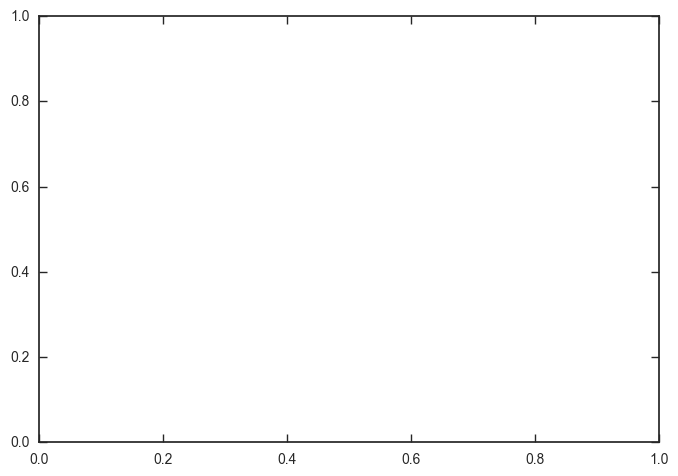

In [3]:
def plot_df(df, t=None, fig=plt.figure(), ax=plt.subplot(111), 
            xlabel="Bin number", ylabel="Pedestal variance", 
            xlim=None, ylim=None, label="Run59775_Ch27"):
    fig=fig 
    ax=ax
    if t is None:
        ax.errorbar(range(df.shape[0]), df.pedvar, yerr=df.dpedvar, label=label)
    else:
        ax.errorbar(t, df.pedvar, yerr=df.dpedvar, label=label)
    if xlim is not None:
        ax.set_xlim(xlim)
    if ylim is not None:
        ax.set_ylim(ylim)
        
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    



In [213]:
def do_hht(fname, trial_dir="test/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-6, plot=True):
    
    df1= read_file(f=fname)

    ro.r("library(hht)")
    ro.r("nimf <- {}".format(N_imf))
    ro.r("trials <- {}".format(N_trials))
    ro.r("imf.list <- 1:{}".format(N_imf_plot))

    ro.r("lc<-read.table(file=\"{}\", sep=\"\", header = FALSE)".format(fname))
    ro.r("lc<-lc[[\"V1\"]]")
    ro.r("sig<-lc")

    ro.r("N=length(sig)")
    ro.r("tn=seq(0,N-1)")
    ro.r("noise.amp <- {}".format(noise_amp))
    ro.r("trials.dir <- \"{}\"".format(trial_dir))
    ro.r("set.seed(628)")
    ro.r("EEMD(lc, tn , noise.amp, trials, nimf, trials.dir = trials.dir)")
    ro.r("EEMD.result <- EEMDCompile(trials.dir, trials, nimf)")
    ro.r("time.span <- c(0, N)")
    eemd_res = ro.r("EEMD.result")
    #time_span = ro.r("time.span")
    #ro.r("")
    if plot:
        _ = plot_hht(eemd_res, plot=True)
    return eemd_res

def do_hht_arr(arr, trial_dir="test/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-6, plot=True):
    
    ro.r("library(hht)")
    ro.r("nimf <- {}".format(N_imf))
    ro.r("trials <- {}".format(N_trials))
    ro.r("imf.list <- 1:{}".format(N_imf_plot))

    #ro.r("lc<-read.table(file=\"{}\", sep=\"\", header = FALSE)".format(t))
    #ro.r("lc<-lc[[\"V1\"]]")
    lc_ = ro.FloatVector(arr)
    ro.globalenv['lc_'] = lc_
    ro.r("sig<-lc_")

    ro.r("N=length(sig)")
    ro.r("tn=seq(0,N-1)")
    ro.r("noise.amp <- {}".format(noise_amp))
    ro.r("trials.dir <- \"{}\"".format(trial_dir))
    ro.r("set.seed(628)")
    ro.r("EEMD(lc_, tn , noise.amp, trials, nimf, trials.dir = trials.dir)")
    ro.r("EEMD.result <- EEMDCompile(trials.dir, trials, nimf)")
    ro.r("time.span <- c(0, N)")
    eemd_res = ro.r("EEMD.result")
    #time_span = ro.r("time.span")
    #ro.r("")
    if plot:
        _ = plot_hht(eemd_res, plot=True)
    return eemd_res


def plot_hht(eemd_res, plot=True):
    df_eemd = pandas2ri.ri2py(eemd_res)
    dict_eemd = dict(zip(df_eemd.names, map(list,list(df_eemd))))
    N_t = len(dict_eemd['original.signal'])
    N_imfs = dict_eemd['nimf'][0]
    imfs = dict_eemd['averaged.imfs']
    N_all_imfs = len(imfs)
    original_signal = dict_eemd['original.signal']
    tt = dict_eemd['tt']

    if plot:
        fig, axes = plt.subplots(N_imfs+1, 1, figsize=(8, 8./4*(N_imfs+1)))

        axes[0].plot(tt, original_signal, label="Original signal")
        axes[0].legend()
        for i in range(N_imfs):
            axes[i+1].plot(tt, imfs[N_t*i:N_t*(i+1)], label="IMF {}".format(i+1))
            axes[i+1].legend()
    return dict_eemd


# Sanity checks:

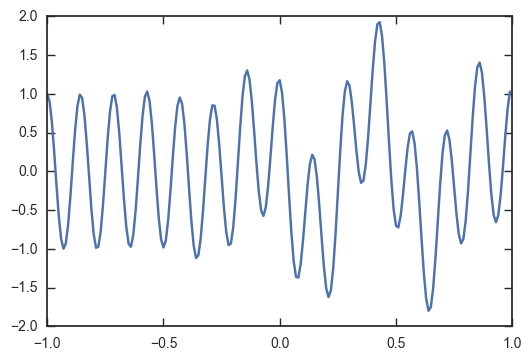

In [215]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 7 * t) + signal.gausspulse(t - 0.4, fc=2)

plt.plot(t, sig)

[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


R object with classes: ('list',) mapped to:
<ListVector - Python:0x1133ae4d0 / R:0x7fc540ed7600>
[IntVe..., IntVe..., Float..., ..., Array, Array, Float...]
  nimf: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x113f421b8 / R:0x7fc542471158>
[       3]
  tt: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x113f42c20 / R:0x7fc54520f570>
[       0,        1,        2, ...,      197,      198,      199]
  original.signal: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x113f427a0 / R:0x7fc53eb1f200>
[1.000282, 0.905016, 0.637494, ..., 0.448410, 0.798554, 1.027624]
  ...
  nimf: <class 'rpy2.robjects.vectors.Array'>
  R object with classes: ('array',) mapped to:
<Array - Python:0x113f42bd8 / R:0x7fc53cc24400>
[0.078160, 0.078160, 0.072738, ..., 0.019847, 0.033550, 0.033550]
  tt: <class 'rpy2.ro

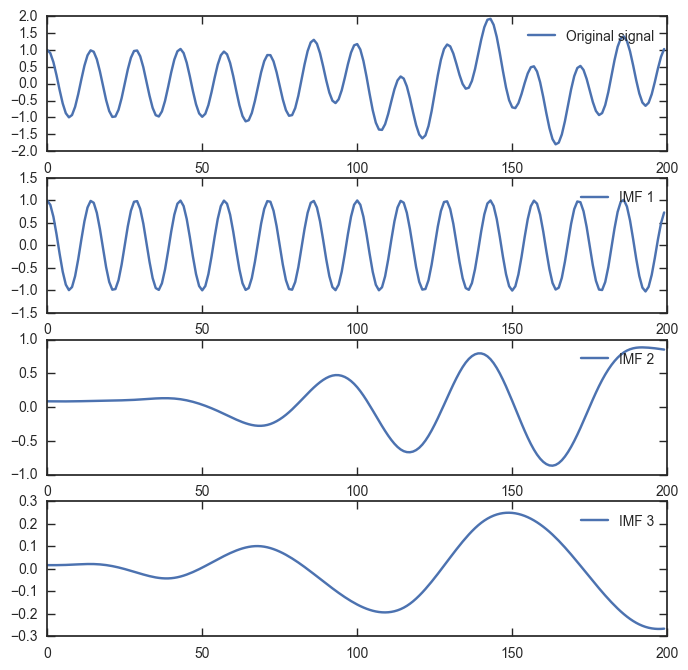

In [216]:
do_hht_arr(sig, trial_dir="test4/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-6, plot=True)


[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


R object with classes: ('list',) mapped to:
<ListVector - Python:0x113726c68 / R:0x7fc541c8a4b0>
[IntVe..., IntVe..., Float..., ..., Array, Array, Float...]
  nimf: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x1130f45a8 / R:0x7fc53bb89938>
[       4]
  tt: <class 'rpy2.robjects.vectors.IntVector'>
  R object with classes: ('integer',) mapped to:
<IntVector - Python:0x1130f44d0 / R:0x7fc54342c0d0>
[       0,        1,        2, ...,      197,      198,      199]
  original.signal: <class 'rpy2.robjects.vectors.FloatVector'>
  R object with classes: ('numeric',) mapped to:
<FloatVector - Python:0x1130f49e0 / R:0x7fc53c3b3a00>
[3.000000, 2.110149, 0.468583, ..., -0.188258, 0.468583, 2.110149]
  ...
  nimf: <class 'rpy2.robjects.vectors.Array'>
  R object with classes: ('array',) mapped to:
<Array - Python:0x1130f4170 / R:0x7fc5466c6e00>
[0.164846, 0.164846, 0.196733, ..., 0.014746, 0.016719, 0.016719]
  tt: <class 'rpy2.r

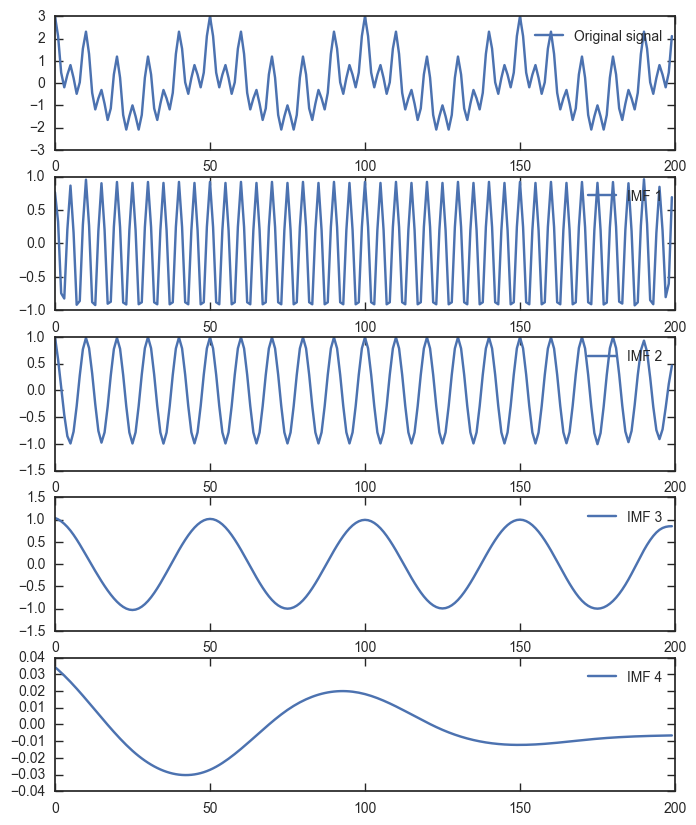

In [217]:
t = np.linspace(-1, 1, 200, endpoint=False)
dt = t[1] - t[0]
sig  = np.cos(2 * np.pi * 10 * t) + np.cos(2 * np.pi * 80 * t) + np.cos(2 * np.pi * 2 * t)

do_hht_arr(sig, trial_dir="test4/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-6, plot=True)



# End of sanity check 

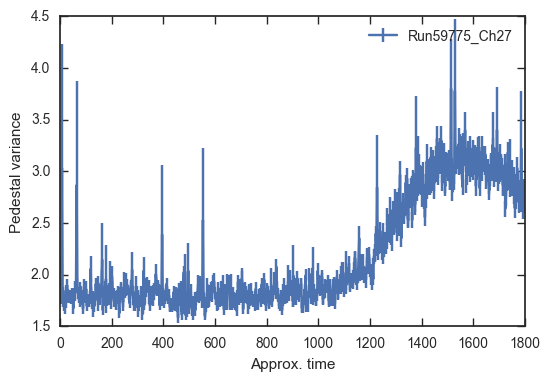

In [218]:
fname="Run59775_Ch356"

df1= read_file(f="Run59775_Ch356")
t = np.linspace(0, 30.*60., df1.shape[0], endpoint=False)
plot_df(df1, t=t, fig=plt.figure(), ax=plt.subplot(111), xlabel="Approx. time", label="Run59775_Ch27")




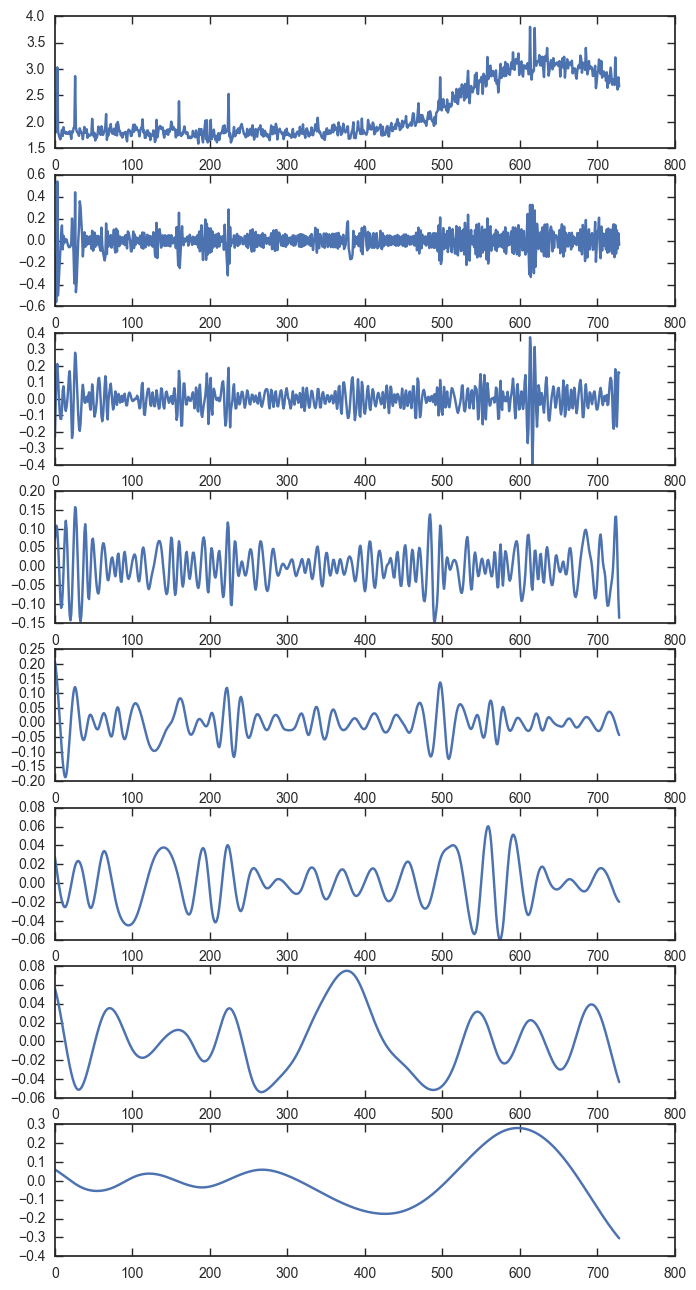

In [219]:
fig, axes = plt.subplots(N_imfs+1, 1, figsize=(8, 8./4*(N_imfs+1)))

axes[0].plot(tt, original_signal, )
for i in range(N_imfs):
    axes[i+1].plot(tt, imfs[N_t*i:N_t*(i+1)])



[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


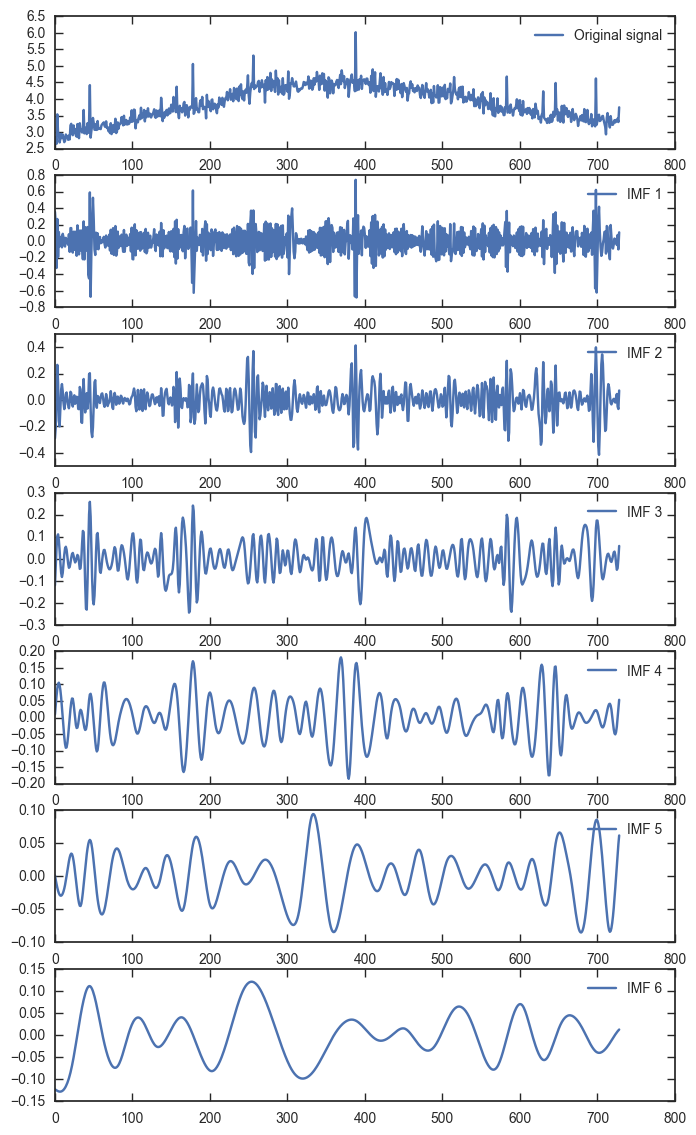

In [201]:
f27="Run59775_Ch27"

eemd_res27 = do_hht(f27, trial_dir="test27/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-6, plot=True)



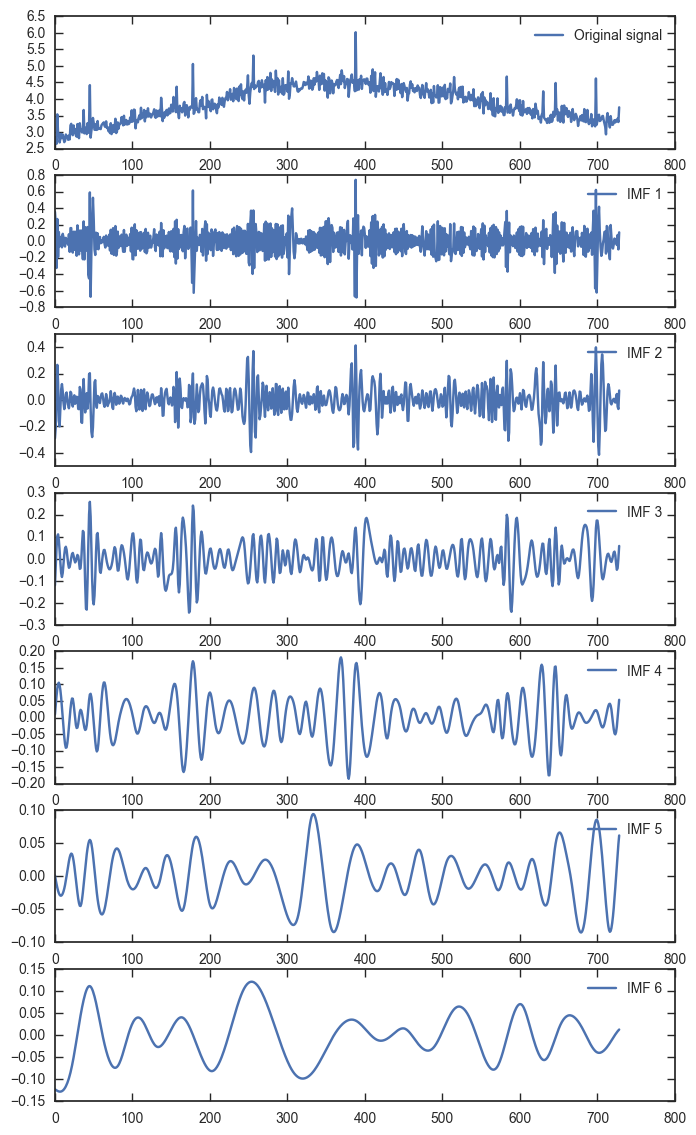

In [205]:
dict_eemd27 = plot_hht(eemd_res27)


In [207]:
dict_eemd27.keys()

['hamp',
 'trials',
 'tt',
 'original.signal',
 'nimf',
 'averaged.imfs',
 'hinstfreq',
 'averaged.residue',
 'averaged.noise']

In [208]:
dict_eemd27['nimf']

[6]

[1] "Created trial directory: test3/"
[1] "TRIAL 1 OF 10 COMPLETE"
[1] "TRIAL 2 OF 10 COMPLETE"
[1] "TRIAL 3 OF 10 COMPLETE"
[1] "TRIAL 4 OF 10 COMPLETE"
[1] "TRIAL 5 OF 10 COMPLETE"
[1] "TRIAL 6 OF 10 COMPLETE"
[1] "TRIAL 7 OF 10 COMPLETE"
[1] "TRIAL 8 OF 10 COMPLETE"
[1] "TRIAL 9 OF 10 COMPLETE"
[1] "TRIAL 10 OF 10 COMPLETE"


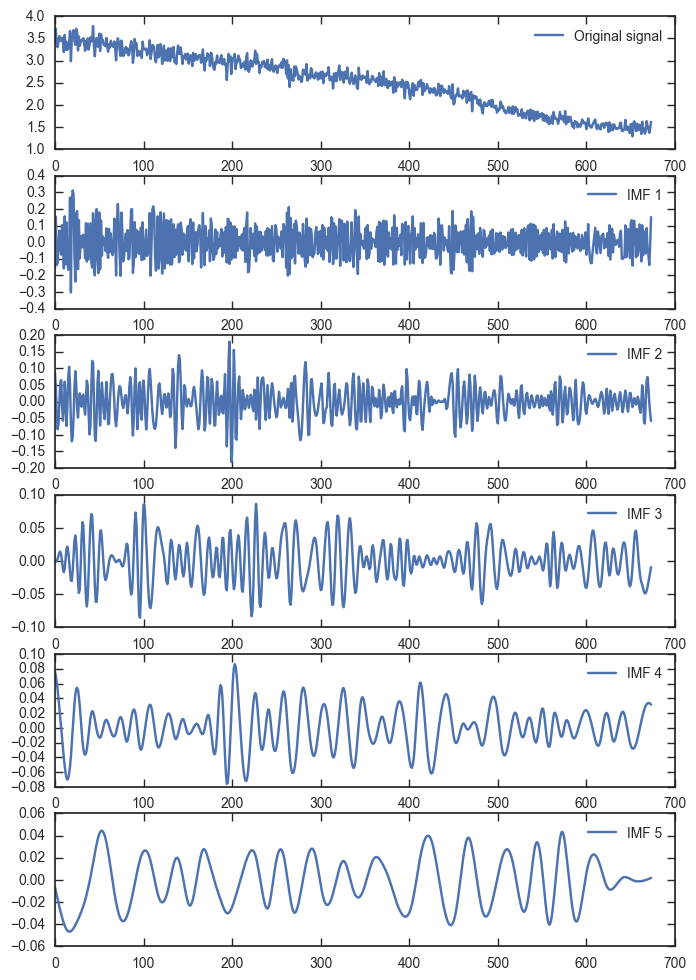

In [209]:
f3="Run59776_Ch194"

eemd_res3 = do_hht(f3, trial_dir="test3/", N_trials=10, N_imf=10, N_imf_plot=8, 
          noise_amp=1e-6, plot=True)


